<a href="https://colab.research.google.com/github/asifbagewadi/melanoma-detection/blob/main/Mohammad_Asif_Bagewadi_Melanoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [6]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [7]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [23]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/skin_diseases'
data_dir_train = pathlib.Path(root_path + "/Train/")
data_dir_test = pathlib.Path(root_path + '/Test/')

In [26]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [27]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [28]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

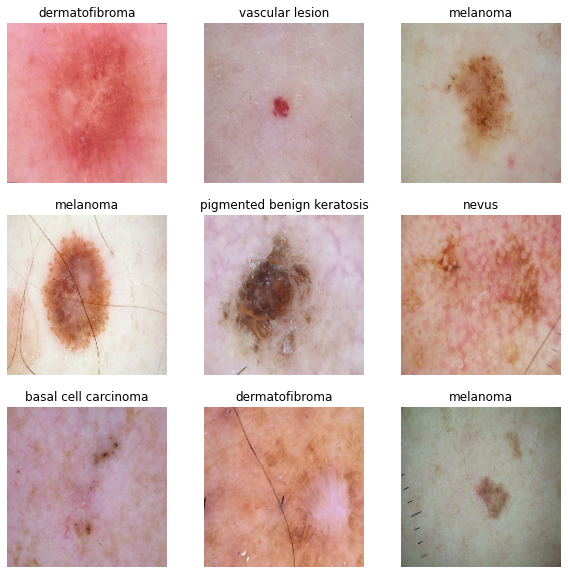

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off") 


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [17]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9,Activation('softmax')))
## Number of classes is 9

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 64)       256       
 ormalization)                                          

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 64)       256       
 ormalization)                                          

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 670s 903ms/step - loss: 17.2400 - accuracy: 0.3016 - val_loss: 2.8622 - val_accuracy: 0.0928
Epoch 2/20
169/169 [==============================] - 11s 65ms/step - loss: 1.9216 - accuracy: 0.3587 - val_loss: 2.7087 - val_accuracy: 0.1537
Epoch 3/20
169/169 [==============================] - 11s 67ms/step - loss: 1.6326 - accuracy: 0.4249 - val_loss: 6.5792 - val_accuracy: 0.1923
Epoch 4/20
169/169 [==============================] - 11s 65ms/step - loss: 1.4631 - accuracy: 0.4629 - val_loss: 18.7722 - val_accuracy: 0.1923
Epoch 5/20
169/169 [==============================] - 11s 65ms/step - loss: 1.4195 - accuracy: 0.4844 - val_loss: 14.9512 - val_accuracy: 0.1656
Epoch 6/20
169/169 [==============================] - 12s 69ms/step - loss: 1.3123 - accuracy: 0.5115 - val_loss: 8.5413 - val_accuracy: 0.2606
Epoch 7/20
169/169 [==============================] - 11s 65ms/step - loss: 1.1774 - accuracy: 0.5517 - val_loss: 3.0709 - val_accu

### Visualizing training results

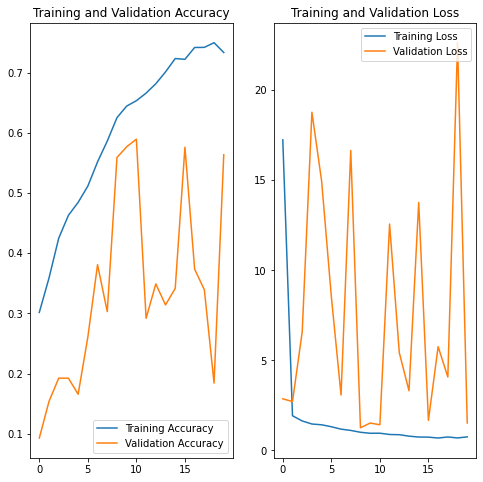

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### It is clearly evident from the above plots that the model has overfit. While the training accuracy is continuously increasing over epochs, the validation accuracy is random and is not rising in any correlation to the training accuracy. The gap is also quite extensive.
### A similar chaotic behaviour is observed in the validation loss.

In [29]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


image_class=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 6739 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


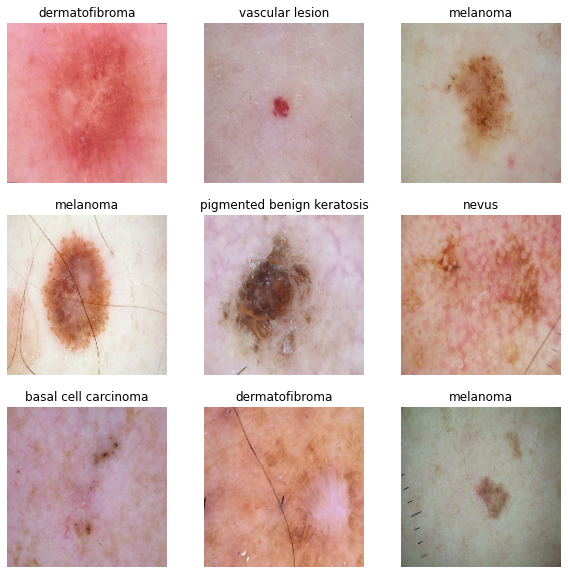

In [30]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))


model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9,Activation('softmax')))
## Number of classes is 9

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 86, 86, 64)       256       
 hNormalization)                                      

### Compiling the model

In [34]:
## Your code goes here
model.compile(optimizer='Adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [35]:
## Your code goes here, note: train your model for 20 epochs
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=23
)

Epoch 1/23
169/169 [==============================] - 33s 170ms/step - loss: 17.3193 - accuracy: 0.2889 - val_loss: 7.4721 - val_accuracy: 0.0965
Epoch 2/23
169/169 [==============================] - 31s 177ms/step - loss: 2.1933 - accuracy: 0.3479 - val_loss: 3.2486 - val_accuracy: 0.1544
Epoch 3/23
169/169 [==============================] - 29s 168ms/step - loss: 1.7054 - accuracy: 0.4013 - val_loss: 2.0856 - val_accuracy: 0.2910
Epoch 4/23
169/169 [==============================] - 29s 167ms/step - loss: 1.5317 - accuracy: 0.4431 - val_loss: 3.8294 - val_accuracy: 0.3229
Epoch 5/23
169/169 [==============================] - 31s 176ms/step - loss: 1.4299 - accuracy: 0.4662 - val_loss: 1.6188 - val_accuracy: 0.4781
Epoch 6/23
169/169 [==============================] - 29s 166ms/step - loss: 1.3119 - accuracy: 0.5135 - val_loss: 7.5746 - val_accuracy: 0.2621
Epoch 7/23
169/169 [==============================] - 32s 178ms/step - loss: 1.2307 - accuracy: 0.5330 - val_loss: 7.2429 - val_a

### Visualizing the results

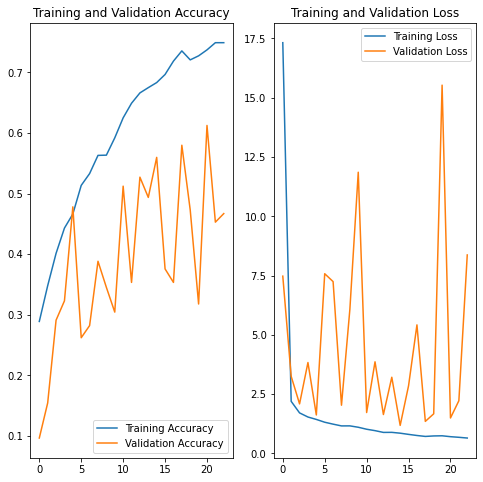

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### **While the validation accuracy has considerable increased from previous compilation, there is still a significant gap between training and validation accuracy. We have reduced overfitting, but could not eliminate it.**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [48]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/skin_diseases/Train/ac...,actinic keratosis
1,/content/gdrive/MyDrive/skin_diseases/Train/ac...,actinic keratosis
2,/content/gdrive/MyDrive/skin_diseases/Train/ac...,actinic keratosis
3,/content/gdrive/MyDrive/skin_diseases/Train/ac...,actinic keratosis
4,/content/gdrive/MyDrive/skin_diseases/Train/ac...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/skin_diseases/Train/va...,vascular lesion
2235,/content/gdrive/MyDrive/skin_diseases/Train/va...,vascular lesion
2236,/content/gdrive/MyDrive/skin_diseases/Train/va...,vascular lesion
2237,/content/gdrive/MyDrive/skin_diseases/Train/va...,vascular lesion


<Figure size 720x720 with 0 Axes>

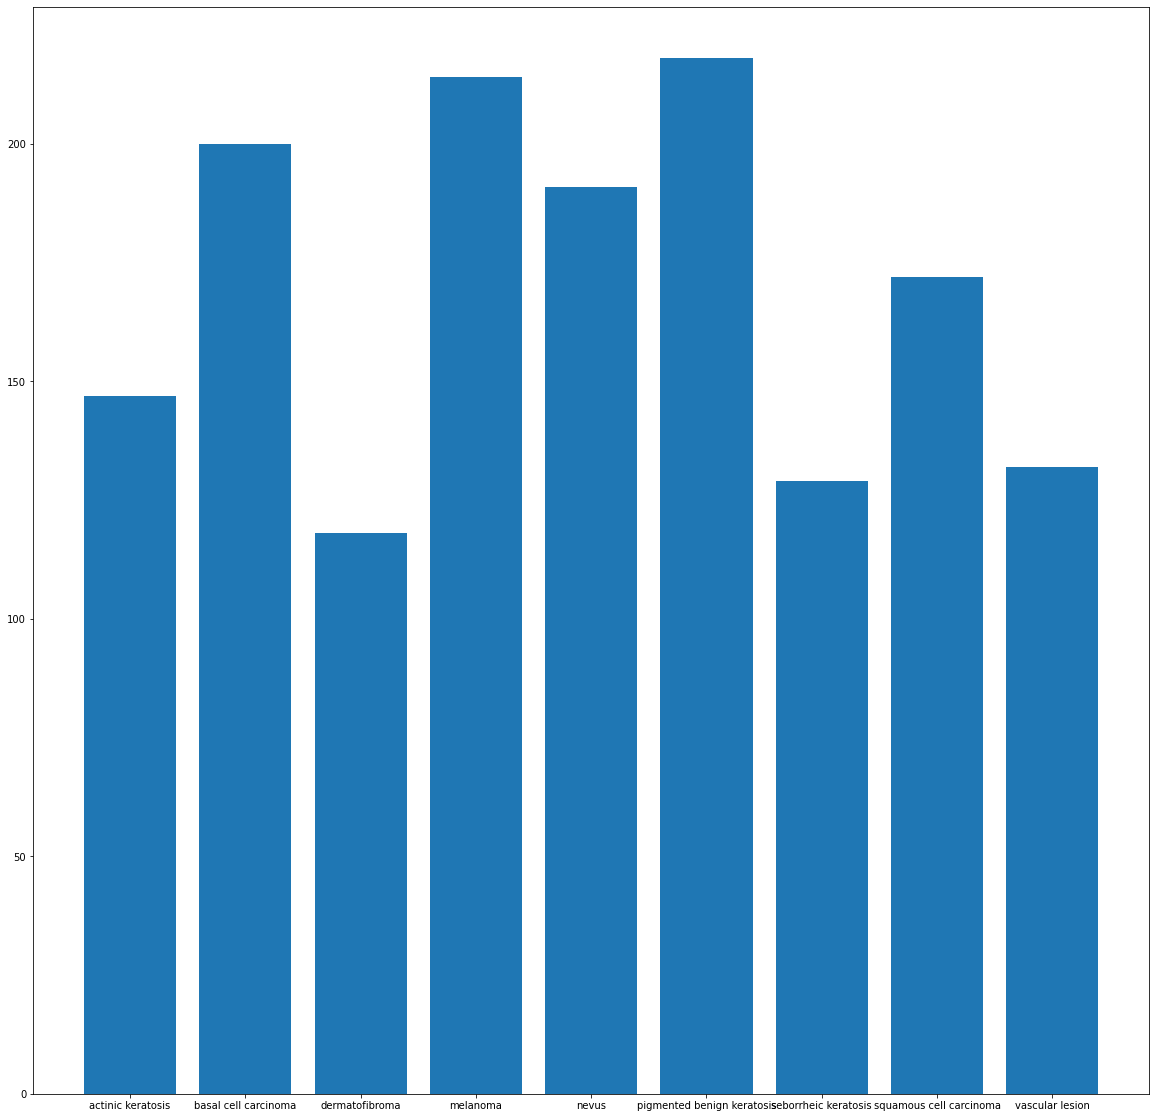

In [37]:
## Your code goes here.
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? >>> **Seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? >>> **Pigmented benign keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [85]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=root_path+ "/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/skin_diseases/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_d8c5d9d9-1d22-48bf-b212-1642ce237b79.jpg',
 '/content/gdrive/MyDrive/skin_diseases/Train/vascular lesion/output/vascular lesion_original_ISIC_0025677.jpg_948564cf-ed13-4c6c-9cd4-ee7240c48c10.jpg',
 '/content/gdrive/MyDrive/skin_diseases/Train/vascular lesion/output/vascular lesion_original_ISIC_0031201.jpg_5c4aebee-678e-4ec9-a095-c7d3a611adf4.jpg',
 '/content/gdrive/MyDrive/skin_diseases/Train/vascular lesion/output/vascular lesion_original_ISIC_0027522.jpg_ce795861-4510-4c5e-86bf-bc9cc98852d6.jpg',
 '/content/gdrive/MyDrive/skin_diseases/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_d01b6e42-8d5e-4cc5-97f7-f65b6a0b71ed.jpg',
 '/content/gdrive/MyDrive/skin_diseases/Train/vascular lesion/output/vascular lesion_original_ISIC_0029448.jpg_8d361f0a-4e17-44d0-92bb-f62cb1b7de0e.jpg',
 '/content/gdrive/MyDrive/skin_diseases/Train/vascular lesion/output/vascula

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [50]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [54]:
data_dir_train=root_path+"/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [56]:
## your code goes here
from tensorflow.keras.regularizers import l2


# from keras.layers import Dense, Dropout, Flatten, BatchNormalization,Conv2D, MaxPooling2D
num_classes = 9
normalization_layer = layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height,img_width,3))
model = Sequential([
    normalization_layer,
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same',
                 activation ='relu',input_shape= (180,180,32)),
    layers.BatchNormalization(),
    layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
#     layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
#     layers.Dropout(0.20),
    layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
#     layers.BatchNormalization(),
    layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
#     layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
#     layers.BatchNormalization(),
    layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
#     layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512,kernel_regularizer=l2(0.001)),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes,activation ='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [57]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [58]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 49s 252ms/step - loss: 3.1457 - accuracy: 0.3173 - val_loss: 7.3138 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - 41s 236ms/step - loss: 2.2524 - accuracy: 0.4273 - val_loss: 4.7377 - val_accuracy: 0.1544
Epoch 3/50
169/169 [==============================] - 42s 244ms/step - loss: 1.9670 - accuracy: 0.4829 - val_loss: 1.9930 - val_accuracy: 0.4759
Epoch 4/50
169/169 [==============================] - 39s 225ms/step - loss: 1.8243 - accuracy: 0.5169 - val_loss: 2.3312 - val_accuracy: 0.4306
Epoch 5/50
169/169 [==============================] - 39s 224ms/step - loss: 1.6715 - accuracy: 0.5708 - val_loss: 1.9892 - val_accuracy: 0.4952
Epoch 6/50
169/169 [==============================] - 36s 208ms/step - loss: 1.5636 - accuracy: 0.6178 - val_loss: 2.0889 - val_accuracy: 0.5063
Epoch 7/50
169/169 [==============================] - 42s 245ms/step - loss: 1.4934 - accuracy: 0.6480 - val_loss: 1.5351 - val_ac

#### **Todo:**  Visualize the model results

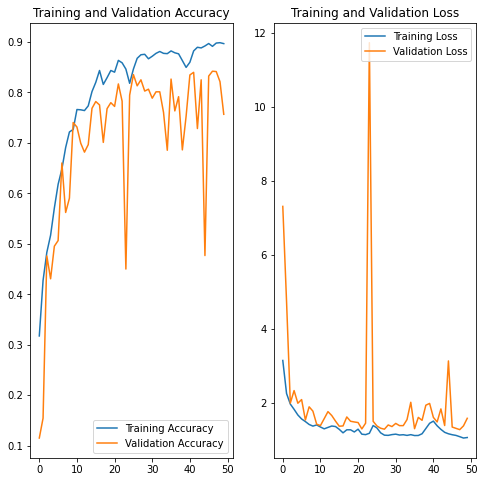

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
accuracy_history_df = pd.DataFrame(data=[{"Type":"Vanilla","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.896513,0.756496,50


Conclusion:
Accuracy on training data has been increased by using Augmentation technique

Model is still overfitting

yes Class rebalance helped upto a certain extent.

The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

Hyperparameter tuning can help the model further.